In [1]:
#本Cell代码用于绘制决策树图形，非本教材重点
#供感兴趣的读者参考，
#决策树构造核心代码从下一cell开始
import matplotlib.pyplot as plt
from math import log
import operator

#图表内嵌中文字体问题
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False 

decisionNode = {'boxstyle':'sawtooth', 'fc':'0.8'}
leafNode = {'boxstyle':'round4', 'fc':'0.8'}
arrow_args = {'arrowstyle':'<-'}

def plotNode(nodeTxt, centerPt, parentPt, nodeType):
    createPlot.ax1.annotate(nodeTxt, xy=parentPt, xycoords='axes fraction', \
                            xytext=centerPt, textcoords='axes fraction', \
                            va="center", ha="center", bbox=nodeType, arrowprops=arrow_args)

def getNumLeafs(myTree):
    numLeafs = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            numLeafs += getNumLeafs(secondDict[key])
        else:
            numLeafs += 1
    return numLeafs

def getTreeDepth(myTree):
    maxDepth = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            thisDepth = getTreeDepth(secondDict[key]) + 1
        else:
            thisDepth = 1
        if thisDepth > maxDepth:
            maxDepth = thisDepth
    return maxDepth

def plotMidText(cntrPt, parentPt, txtString):
    xMid = (parentPt[0] - cntrPt[0]) / 2.0 + cntrPt[0]
    yMid = (parentPt[1] - cntrPt[1]) / 2.0 + cntrPt[1]
    createPlot.ax1.text(xMid, yMid, txtString)

def plotTree(myTree, parentPt, nodeTxt):
    numLeafs = getNumLeafs(myTree)
    depth = getTreeDepth(myTree)
    firstStr = list(myTree.keys())[0]
    cntrPt = (plotTree.xOff + (1.0 + float(numLeafs)) / 2.0 / plotTree.totalw, plotTree.yOff)
    plotMidText(cntrPt, parentPt, nodeTxt)
    plotNode(firstStr, cntrPt, parentPt, decisionNode)
    secondDict = myTree[firstStr]
    plotTree.yOff = plotTree.yOff - 1.0 / plotTree.totalD
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            plotTree(secondDict[key], cntrPt, str(key))
        else:
            plotTree.xOff = plotTree.xOff + 1.0 / plotTree.totalw
            plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff), cntrPt, leafNode)
            plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key))
    plotTree.yOff = plotTree.yOff + 1.0 / plotTree.totalD

def createPlot(inTree):
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    #axprops = {'xticks'=[], 'yticks'=[]}
    #createPlot.ax1 = plt.subplot(111, frameon=False, **axprops)
    createPlot.ax1 = plt.subplot(111)
    plotTree.totalw = float(getNumLeafs(inTree))
    plotTree.totalD = float(getTreeDepth(inTree))
    plotTree.xOff = -0.5 / plotTree.totalw
    plotTree.yOff = 1.0
    plotTree(inTree, (0.5, 1.0), '')
    plt.savefig('决策树.png',dpi=300, bbox_inches='tight')
    plt.show()

In [2]:
#DecsionTree算法
#构建数据集
def createDataSet():
    dataSet = [[0, 2, 0, 0, 'N'], 
               [0, 2, 0, 1, 'N'], 
               [1, 2, 0, 0, 'Y'], 
               [2, 1, 0, 0, 'Y'], 
               [2, 0, 1, 0, 'Y'], 
               [2, 0, 1, 1, 'N'], 
               [1, 0, 1, 1, 'Y'],
               [0, 1, 0, 0, 'N'], 
               [0, 0, 1, 0, 'Y'], 
               [2, 1, 1, 0, 'Y'], 
               [0, 1, 1, 1, 'Y'], 
               [1, 1, 0, 1, 'Y'], 
               [1, 2, 1, 0, 'Y'],
               [2, 1, 0, 1, 'N']]
    labels = ['Age', 'Income', 'Job', 'Credit']
    return dataSet, labels

dS1,lab = createDataSet()
print(dS1)
print(lab)

[[0, 2, 0, 0, 'N'], [0, 2, 0, 1, 'N'], [1, 2, 0, 0, 'Y'], [2, 1, 0, 0, 'Y'], [2, 0, 1, 0, 'Y'], [2, 0, 1, 1, 'N'], [1, 0, 1, 1, 'Y'], [0, 1, 0, 0, 'N'], [0, 0, 1, 0, 'Y'], [2, 1, 1, 0, 'Y'], [0, 1, 1, 1, 'Y'], [1, 1, 0, 1, 'Y'], [1, 2, 1, 0, 'Y'], [2, 1, 0, 1, 'N']]
['Age', 'Income', 'Job', 'Credit']


In [3]:
#计算数据集的信息熵
#参数：dataset-List列表，训练集，包含了样本数据和分类结果
#返回值：shannonEnt-浮点数，训练集的香农熵
def calcShannonEnt(dataSet):
    numEntries = len(dataSet)
    labelCounts = {}
    for featVec in dataSet:
#featVec[-1]表示列表featVec中的最后一项，就是Y/N的分类结果        
        currentLabel = featVec[-1]
#对currentLabel计数，对应的分类为Y/N的样本各有多少个
        if currentLabel not in labelCounts.keys():
            labelCounts[currentLabel] = 0
        labelCounts[currentLabel] += 1
    shannonEnt = 0.0
#计算信息熵
    for key in labelCounts:
        prob = float(labelCounts[key])/numEntries
        shannonEnt -= prob * log(prob, 2)
    return shannonEnt

snEnt = calcShannonEnt(dS1)
print('原始数据集香农熵：')
print(snEnt)

原始数据集香农熵：
0.9402859586706309


In [4]:
#按照feat指定的标签分割数据集
#参数：dataset-List列表，待分割样本集合
#      axie-数值，属性列表项序号，按照此属性的取值来分割样本集合
#      value-数值，属性取值
#返回值：retDataSet-List列表，分割后的样本集合，去除了分割属性
def splitDataSet(dataSet, axis, value):
    retDataSet = []
    for featVec in dataSet:
        if featVec[axis] == value:
            reduceFeatVec = featVec[:axis]
            reduceFeatVec.extend(featVec[axis+1:])
            retDataSet.append(reduceFeatVec)
    return retDataSet

print('splitDataSet函数示例')
print('将原始样本分割出Income（在labels中序号为1）值为0的集合：')
retDS1 = splitDataSet(dS1,1, 0)
print(retDS1)

splitDataSet函数示例
将原始样本分割出Income（在labels中序号为1）值为0的集合：
[[2, 1, 0, 'Y'], [2, 1, 1, 'N'], [1, 1, 1, 'Y'], [0, 1, 0, 'Y']]


In [5]:
#决策树ID3算法
#按照信息熵增益来确定用于分割的属性
#参数：dataset-List列表，待分割样本集合
#返回值：bestFeature-数值，分割属性对应在labels中的序号
def ID3(dataSet):
#属性数量=样本列表元素数量-1（最后一项是分类结果，不是属性）
    numFeatures = len(dataSet[0]) - 1
#计算原始数据集信息熵
    baseEntropy = calcShannonEnt(dataSet)
    bestInfoGain= 0.0
    bestFeature = -1
    for i in range(numFeatures):
#当前属性下，所有样本的值构成列表
        featList = [example[i] for example in dataSet]
        uniqueVals = set(featList)
        newEntropy = 0.0
        for value in uniqueVals:
#当使用该属性分割时，计算其香农信息熵
            subDataSet = splitDataSet(dataSet, i, value)
            prob = len(subDataSet)/float(len(dataSet))
            newEntropy += prob * calcShannonEnt(subDataSet)
        infoGain = baseEntropy - newEntropy
#找出最大熵增益对应的属性
        if (infoGain > bestInfoGain):
            bestInfoGain = infoGain
            bestFeature = i
    return bestFeature

bFID3=ID3(dS1)
print('ID3第一次选择的最佳分割属性:')
print(bFID3)

ID3第一次选择的最佳分割属性:
0


In [6]:
#决策树C45算法
#按照信息熵增益率来确定用于分割的属性
#参数：dataset-List列表，待分割样本集合
#返回值：bestFeature-数值，分割属性对应在labels中的序号
def C45(dataSet):
    numFeatures = len(dataSet[0]) - 1
    baseEntropy = calcShannonEnt(dataSet)
#用于找出最大增益率的变量
    bestInfoGainRatio = 0.0
    bestFeature = -1
    for i in range(numFeatures):
        featList = [example[i] for example in dataSet]
        uniqueVals = set(featList)
        newEntropy = 0.0
#用于计算分离信息
        splitInfo = 0.0
        for value in uniqueVals:
            subDataSet = splitDataSet(dataSet, i, value)
            prob = len(subDataSet)/float(len(dataSet))
            newEntropy += prob * calcShannonEnt(subDataSet)
            splitInfo += -prob * log(prob, 2)
        infoGain = baseEntropy - newEntropy
        if (splitInfo == 0): 
            continue
#属性选取标准改为增益率
        infoGainRatio = infoGain / splitInfo
        if (infoGainRatio > bestInfoGainRatio):
            bestInfoGainRatio = infoGainRatio
            bestFeature = i
    return bestFeature

bFC45=C45(dS1)
print('C45第一次选择的最佳分割属性:')
print(bFC45)

C45第一次选择的最佳分割属性:
0


In [7]:
#辅助函数majorityCnt
#当按照当前决策树路径使用了所有的属性分割得到的子集中，
#仍然有不同分类标签的样本时，取出现次数多的分类标签作为该子集的分类结果。
#参数：classList-List列表，分割子集的分类标签
#返回值：sortedClassCount[0][0]-数值，排序出现最多的分类标签值
def majorityCnt(classList):
    classCount = {}
    for vote in classList:
        if vote not in classCount.keys():
            classCount[vote] = 0
        classCount[vote] += 1
    sortedClassCount = sorted(classCount.iteritems(), key=operator.itemgetter(1), reversed=True)
    return sortedClassCount[0][0]

#核心任务函数createTree，调用ID3或者C4.5算法构造决策树
#参数：dataset-List列表，样本集
#      labels-List列表，样本属性集
#返回值：myTree-Dict字典，生成的决策树
def createTree(dataSet, labels):
#拷贝，createTree会改变labels
    classList = [example[-1] for example in dataSet]
    if classList.count(classList[0]) == len(classList):
#类别完全相同，停止划分
        return classList[0]
    if len(dataSet[0]) == 1:
#遍历完所有特征时返回出现次数最多的
        return majorityCnt(classList)
#可以使用ID3或者C45算法
#    bestFeat = ID3(dataSet)
    bestFeat = C45(dataSet)
    bestFeatLabel = labels[bestFeat]
    myTree = {bestFeatLabel:{}}
    del(labels[bestFeat])
#得到列表包括节点所有的属性值
    featValues = [example[bestFeat] for example in dataSet]
    uniqueVals = set(featValues)
    for value in uniqueVals:
        subLabels = labels[:]
        myTree[bestFeatLabel][value] = createTree(splitDataSet(dataSet, bestFeat, value), subLabels)
    return myTree

构造出的决策树：
{'Age': {0: {'Job': {0: 'N', 1: 'Y'}}, 1: 'Y', 2: {'Credit': {0: 'Y', 1: 'N'}}}}


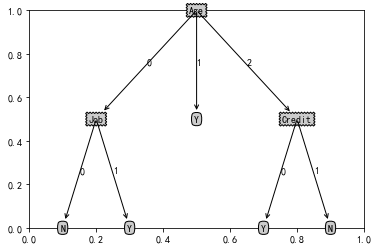

In [8]:
#结果显示
#createTree会改变lab,因此传入它的副本
lab_temp = lab[:]
mTr=createTree(dS1,lab_temp)
print('构造出的决策树：')
print(mTr)
#调用Cell1中实现的createPlot函数绘制决策树。
createPlot(mTr)

In [9]:
#classify函数使用生成的决策树模型，对测试样本进行分类
#参数：inputTree-Dict字典，生成的决策树
#      featLabels-List列表，样本属性集
#      testVec-List列表，测试样本
#返回值：classLabel-List列表项，分类结果
def classify(inputTree, featLabels, testVec):
    firstStr = list(inputTree.keys())[0]
    secondDict = inputTree[firstStr]
    featIndex = featLabels.index(firstStr)
#递归调用自身，沿着树节点往下查询
    for key in secondDict.keys():
        if testVec[featIndex] == key:
            if type(secondDict[key]).__name__ == 'dict':
                classLabel = classify(secondDict[key], featLabels, testVec)
            else:
                classLabel = secondDict[key]
    return classLabel


tsVec = [0, 2, 0, 1]
print('classifyResult:\n', classify(mTr, lab, tsVec))

classifyResult:
 N


读入的数据文件首5行：
    客户ID  工龄  岗位性质  教育程度  婚姻状态 销售结果
0  10001   1     2     1     1    N
1  10002   1     2     3     1    N
2  10003   1     3     4     1    Y
3  10004   4     2     2     1    Y
4  10005   1     1     3     2    Y
转化后的2维列表前5项：
[[1, 2, 1, 1, 'N'], [1, 2, 3, 1, 'N'], [1, 3, 4, 1, 'Y'], [4, 2, 2, 1, 'Y']]
['工龄', '工作性质', '教育程度', '婚姻状况']
构造出的决策树：
{'婚姻状况': {1: {'工龄': {1: {'教育程度': {1: 'N', 2: 'N', 3: 'N', 4: 'Y'}}, 2: {'教育程度': {1: 'N', 2: 'N', 3: 'N', 4: 'Y'}}, 3: {'教育程度': {1: 'N', 2: 'N', 3: 'N', 4: 'Y'}}, 4: 'Y'}}, 2: 'Y'}}


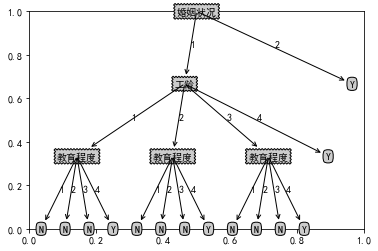

In [10]:
import numpy as np
import pandas as pd

#读取excel文件，将原来二值表格转换为2维列表，用于后续处理
#参数：fname-excel文件名
#返回值：data2Dlist-2维列表
def loadExcel(fname):
    data2Dlist=[]
    pd1 = pd.read_excel(fname,'Sheet1')
    print('读入的数据文件首5行：')
    print(pd1.head())
    for index ,row in pd1.iterrows():
        list1 = row.tolist()
        list1.pop(0)
        data2Dlist.append(list1)
#显示2维列表前5项
    print('转化后的2维列表前5项：')
    print(data2Dlist[:4])
#返回该2维列表
    return data2Dlist

BMData=loadExcel('ch10_bankMarketing_info.xlsx')
BMLabel= ['工龄', '工作性质', '教育程度', '婚姻状况']
print(BMLabel)

#结果显示
#createTree会改变lab,因此传入它的副本
lab_temp = BMLabel[:]
BMTree=createTree(BMData,lab_temp)
print('构造出的决策树：')
print(BMTree)
#调用Cell1中实现的createPlot函数绘制决策树。
createPlot(BMTree)

In [11]:
#对新用户购买产品进行分类预测
BMVec = [2, 2, 3, 2]
print('classifyResult:\n', classify(BMTree, BMLabel, BMVec))

classifyResult:
 Y


构造出的决策树：
{'Income': {0: 'N', 1: {'Marriage': {0: 'Y', 1: 'N', 2: 'Y'}}, 2: 'N'}}


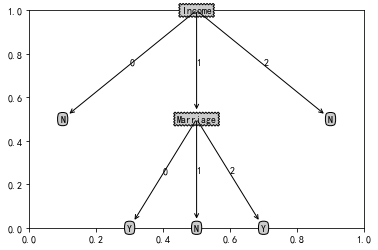

classifyResult:
 N


In [12]:
'''
复习思考题1：表 9 4记录已有的用户是否可以偿还债务。如果新来一个用户：无房产，单身，年收入55K。预测该客户是否有能力偿还债务。
'''
#构建数据集
#年收入分为3段：[0,75]=0;(75,120)=1;[120,]=2
def createDataSet1():
    dataSet = [[1, 0, 2, 'N'], 
               [0, 1, 1, 'N'], 
               [0, 0, 0, 'N'], 
               [1, 1, 2, 'N'], 
               [0, 2, 1, 'Y'], 
               [0, 1, 0, 'N'], 
               [1, 2, 2, 'N'],
               [0, 0, 1, 'Y'], 
               [0, 1, 0, 'N'], 
               [0, 0, 1, 'Y']] 
    labels=['House', 'Marriage', 'Income', 'Credit']
    return dataSet, labels

dS1,lab = createDataSet1()
lab_temp = lab[:]
mTr=createTree(dS1,lab_temp)
print('构造出的决策树：')
print(mTr)
#调用Cell1中实现的createPlot函数绘制决策树。
createPlot(mTr)

NewCustom = [0, 0, 0]
print('classifyResult:\n', classify(mTr,lab, NewCustom))

构造出的决策树：
{'House': {0: {'Job': {0: 'N', 1: 'Y'}}, 1: 'Y'}}


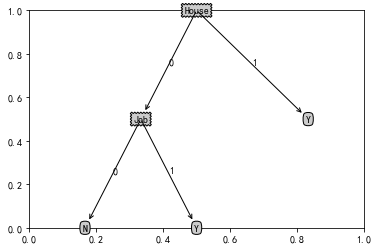

In [13]:
'''
复习思考题2：给出表 9 5的贷款申请样本数据，希望通过所给的训练数据学习一个贷款申请的决策树，用于对未来的贷款申请进行分类，
即当新的客户提出贷款申请时，根据申请人的特征利用决策树决定是否批准贷款申请。
'''
#构建数据集
def createDataSet2():
    dataSet = [[0, 0, 0, 0, 'N'], 
               [0, 0, 0, 1, 'N'], 
               [0, 1, 0, 1, 'Y'], 
               [0, 1, 1, 0, 'Y'], 
               [0, 0, 0, 0, 'N'], 
               [1, 0, 0, 0, 'N'], 
               [1, 0, 0, 1, 'N'],
               [1, 1, 1, 1, 'Y'], 
               [1, 0, 1, 2, 'Y'], 
               [1, 0, 1, 2, 'Y'], 
               [2, 0, 1, 2, 'Y'], 
               [2, 0, 1, 1, 'Y'], 
               [2, 1, 0, 1, 'Y'],
               [2, 1, 0, 2, 'Y'],
               [2, 0, 0, 1, 'N']]
    labels = ['Year', 'Job', 'House', 'Credit']
    return dataSet, labels

dS1,lab = createDataSet2()
lab_temp = lab[:]
mTr=createTree(dS1,lab_temp)
print('构造出的决策树：')
print(mTr)
#调用Cell1中实现的createPlot函数绘制决策树。
createPlot(mTr)